In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot


In [107]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        6505 non-null   datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  6504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.8 KB


In [108]:
data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"y",
        "Date":"ds"
    }
)

In [109]:
data = data.fillna(method = 'pad')
print(data.isnull().sum())

ds    0
y     0
dtype: int64


In [110]:
# data['ds'] = pd.to_datetime(data['ds'], format = "%d/%m/%Y")

In [111]:
data = data.set_index('ds')

In [112]:
data = data.sort_values(by = 'ds')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2020-01-07': '2022-11-15'] # 7 Jan 2021  to 1 Mar 2022 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test)) 

Length of Train Data:  5783
Length of Test Data:  722


In [113]:
data = data.reset_index()

In [114]:
data

,ds,y
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00
...,...,...
6500,2022-11-09,3.46
6501,2022-11-10,4.80
6502,2022-11-11,4.80
6503,2022-11-14,6.24


In [115]:
model = Prophet()
model.fit(data)
future = model.make_future_dataframe(periods = 100, freq='D')
forecast = model.predict(future)
# print(forecast)
print(future)
# Plot the forecast
# model.plot(forecast, xlabel="Year", ylabel="Price ($/MMBtu)")
# plt.title("Natural Gas Price Forecast")
# plt.show()
# forecast = forecast[6506:]
# print(forecast)

10:22:30 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing


             ds
0    1997-01-07
1    1997-01-08
2    1997-01-09
3    1997-01-10
4    1997-01-13
...         ...
6600 2023-02-19
6601 2023-02-20
6602 2023-02-21
6603 2023-02-22
6604 2023-02-23

[6605 rows x 1 columns]


In [116]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

             ds      yhat  yhat_lower  yhat_upper
0    1997-01-07  2.654295    0.981208    4.193057
1    1997-01-08  2.671156    1.009087    4.258979
2    1997-01-09  2.651174    1.017324    4.179866
3    1997-01-10  2.590933    1.122917    4.133398
4    1997-01-13  2.607064    0.971249    4.157634
...         ...       ...         ...         ...
6600 2023-02-19  3.722849    2.160571    5.270422
6601 2023-02-20  5.310898    3.767700    6.984718
6602 2023-02-21  5.338579    3.735777    6.763734
6603 2023-02-22  5.347293    3.799246    7.013473
6604 2023-02-23  5.317839    3.721983    6.933521

[6605 rows x 4 columns]


In [124]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

           date      yhat  yhat_lower  yhat_upper
6505 2022-11-16  4.997790    3.476971    6.531533
6506 2022-11-17  4.986668    3.507718    6.555130
6507 2022-11-18  4.939671    3.412449    6.539791
6508 2022-11-19  5.582961    3.913306    7.180118
6509 2022-11-20  3.407406    1.880880    5.064233
...         ...       ...         ...         ...
6600 2023-02-19  3.722849    2.160571    5.270422
6601 2023-02-20  5.310898    3.767700    6.984718
6602 2023-02-21  5.338579    3.735777    6.763734
6603 2023-02-22  5.347293    3.799246    7.013473
6604 2023-02-23  5.317839    3.721983    6.933521

[100 rows x 4 columns]


In [118]:
data['yhat'] = forecast['yhat']


In [119]:
data1 = pd.read_csv('forecast.csv')

data1 = data1.drop('predicted_mean', axis=1)

forecast['ds'] = pd.to_datetime(forecast['ds'])
data1['date'] = pd.to_datetime(data1['date'])

forecast.columns.values[0] = 'date'

In [121]:
df_merged = pd.merge(data1, forecast[['ds', 'yhat']], on='date', how='inner')

In [122]:
df_merged

,date,gas_price,yhat
0,2022-11-16,5.88,4.997790
1,2022-11-17,6.20,4.986668
2,2022-11-18,6.10,4.939671
3,2022-11-21,6.23,5.021348
4,2022-11-22,6.27,5.079648
...,...,...,...
61,2023-02-15,2.45,5.365391
62,2023-02-16,2.48,5.349097
63,2023-02-17,2.28,5.291685
64,2023-02-21,2.12,5.338579


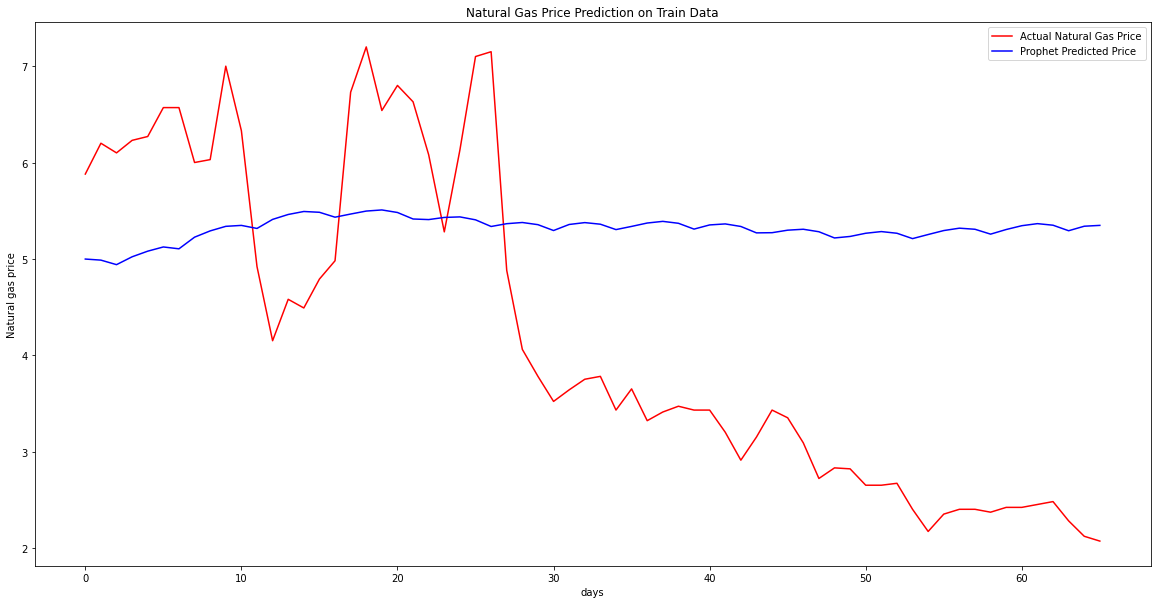

In [125]:
plt.figure(figsize = (20, 10))
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['yhat'], color = 'blue', label = 'Prophet Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_merged['gas_price'], df_merged['yhat'])

3.902730877730345

In [127]:
# model.plot(forecast, uncertainty=True)

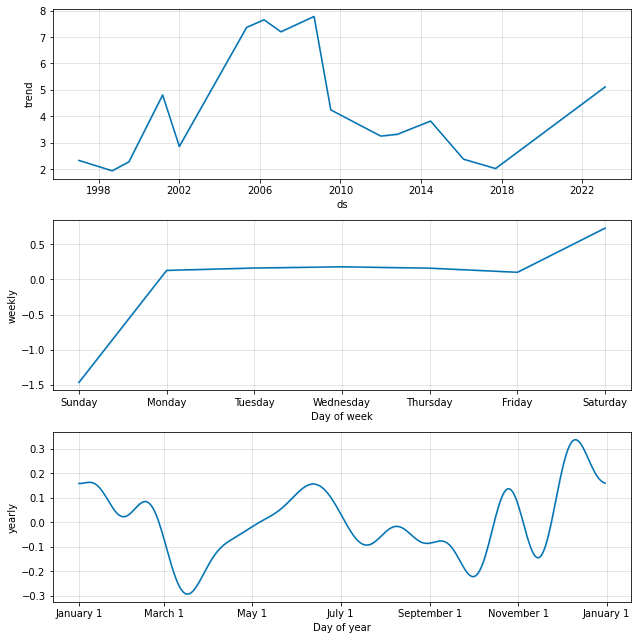

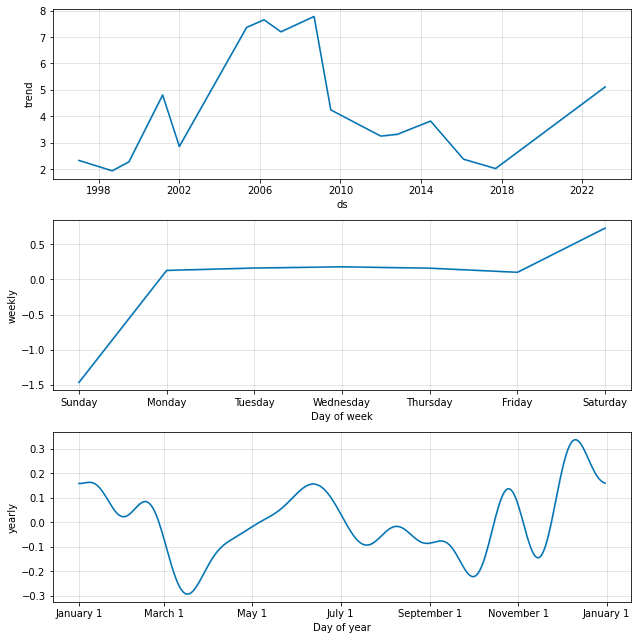

In [129]:
model.plot_components(forecast)

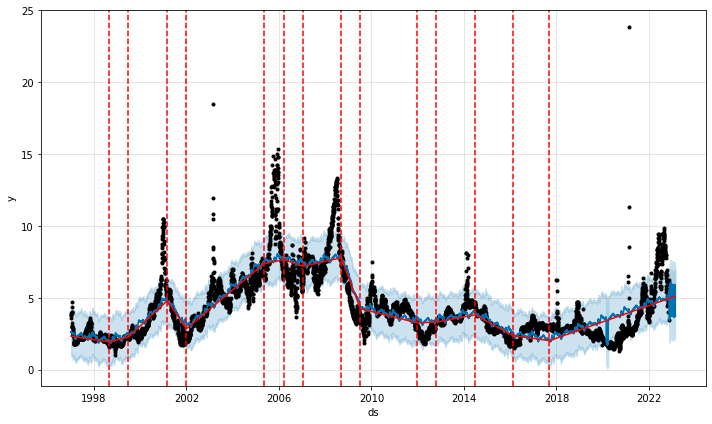

In [130]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

10:28:42 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing


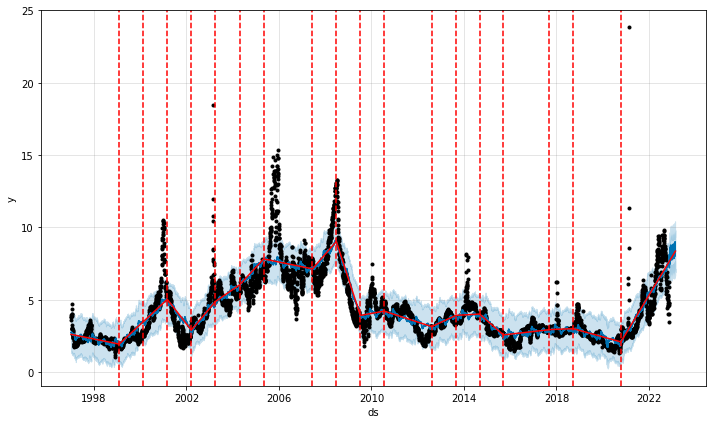

In [131]:
pro_change= Prophet(changepoint_range=1)
forecast = pro_change.fit(data).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)